<a href="https://colab.research.google.com/github/Lakshman511/EVA4/blob/master/S6/EVA4_S6_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:

# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       #transforms.RandomErasing(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
# a class to maintain misclassified images,train loss,test loss values and also to plot graphs
class StatsManager:
  def __init__(self):
    self.data={"mis_classified_images":[],"pred":[],"target":[],"train_loss":[],"test_loss":[],"train_accuracy":[],"test_accuracy":[]}
  def append_train_loss(self,loss):
    self.data["train_loss"].append(loss)
  def append_test_loss(self,loss):
    self.data["test_loss"].append(loss)
  def append_train_accuracy(self,acc):
    self.data["train_accuracy"].append(acc)
  def append_test_accuracy(self,acc):
    self.data["test_accuracy"].append(acc)
  def append_misclassified_images(self,data1,pred,target):
    for j in range(len(pred)):
      if(pred[j]!=target[j]):
        self.data['pred'].append(pred[j])
        self.data['target'].append(target[j])
        self.data["mis_classified_images"].append(data1[j,:,:,:])
  def plot_misclassified_25(self):
    figure = plt.figure(figsize=(10,10))
    num_of_images = 25
    for index in range(1, num_of_images + 1):
      plt.subplot(5, 5, index)
      plt.axis('off')
      plt.annotate("Pred: "+str(self.data["pred"][-index].cpu().item())+" Tar:"+str(self.data["target"][-index].cpu().item()),(3,3))
      plt.imshow(self.data["mis_classified_images"][-index].cpu().numpy().squeeze(), cmap='gray_r')
  def plot_losses(self):
    plt.figure(figsize=(15,10))
    plt.plot(self.data["train_loss"])
    plt.plot(self.data["test_loss"])
    plt.title('model losses')
    plt.ylabel('losses')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
  def plot_accuracies(self):
    plt.figure(figsize=(15,10))
    plt.plot(self.data["train_accuracy"])
    plt.plot(self.data["test_accuracy"])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 1, 28, 28])
torch.Size([128])


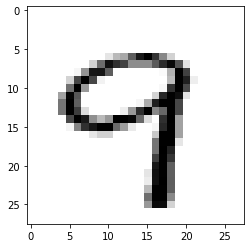

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

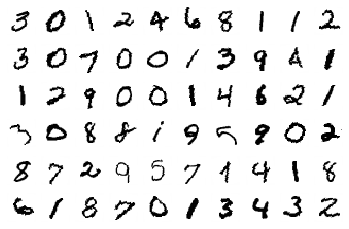

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

## Target
1. Less than 8000 parameters
2. Less than 15 epochs
3. Test with Cyclic LR
4. Add small dropout of 4%

## Results
1. Number of Parameters = 7618 + 140 non trainable BN params
2. Best Train Accuracy = 99.18
3. Best Test Accuracy = 99.63

## Analysis
1. As expected the cyclic LR worked better. We want to further bunp up the LR because there is still room.
2. Can increase dropouts more to further bump up the challenge. We are happy to be below 8000.

In [0]:
dropout_value = 0.04
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Convolution Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_side = 28, output_size = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 28, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 10, RF = 14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8, RF = 18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6, RF = 22

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 4, RF = 26

        # OUTPUT BLOCK
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 26

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
           Dropout-3           [-1, 10, 28, 28]               0
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
           Dropout-7           [-1, 10, 28, 28]               0
              ReLU-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

In [0]:
class ModelTrainTester():
  def __init__(self):
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.sm=StatsManager()
  def train(self,model, device, train_loader, optimizer, epoch,scheduler,L1lambda=None,L2lambda=None):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    t_loss=0
    i=0
    for batch_idx, (data, target) in enumerate(pbar):
    # get samples
      data, target = data.to(device), target.to(device)
      i+=1
    # Init
      optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
      y_pred = model(data)

    # Calculate loss
      loss = F.nll_loss(y_pred, target)
      if L1lambda is not None:
        #l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0.
        for param in model.parameters():
          #reg_loss += l1_crit(param)
          reg_loss += torch.sum(param.abs())
        loss += L1lambda * reg_loss
      t_loss+=loss
      self.train_losses.append(loss)
    # Backpropagation
      loss.backward()
      optimizer.step()

    # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)
       # get the index of the max log-probability
      self.sm.append_misclassified_images(data,pred,target.view_as(pred))
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
    self.sm.append_train_loss(t_loss/i)
    self.train_epoch_end.append(self.train_acc[-1])
    self.sm.append_train_accuracy(self.train_acc[-1])
  def test(self,model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            self.sm.append_misclassified_images(data,pred,target.view_as(pred))  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    self.sm.append_test_loss(test_loss)
    
    self.test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    self.sm.append_test_accuracy(100. * correct / len(test_loader.dataset))
    self.test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
m1=ModelTrainTester()

# Let's Train and test our model

In [0]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    m1.train(model, device, train_loader, optimizer, epoch, scheduler)
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    #scheduler.step()
    m1.test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10280025005340576 Batch_id=468 Accuracy=80.37: 100%|██████████| 469/469 [00:17<00:00, 26.69it/s]


Epoch: 0 LR: [0.005636138390090167]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0907, Accuracy: 9778/10000 (97.78%)

EPOCH: 1


Loss=0.04693681374192238 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]

Epoch: 1 LR: [0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Accuracy: 9814/10000 (98.14%)

EPOCH: 2


Loss=0.05092572793364525 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:16<00:00, 35.69it/s]

Epoch: 2 LR: [0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9851/10000 (98.51%)

EPOCH: 3


Loss=0.1040726900100708 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:16<00:00, 35.51it/s]

Epoch: 3 LR: [0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9852/10000 (98.52%)

EPOCH: 4


Loss=0.12284304946660995 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:16<00:00, 32.55it/s]

Epoch: 4 LR: [0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9890/10000 (98.90%)

EPOCH: 5


Loss=0.07385862618684769 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:16<00:00, 36.14it/s]

Epoch: 5 LR: [0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.01289166510105133 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]

Epoch: 6 LR: [0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9894/10000 (98.94%)

EPOCH: 7


Loss=0.023651227355003357 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]

Epoch: 7 LR: [0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.027113119140267372 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]

Epoch: 8 LR: [0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.031529005616903305 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]

Epoch: 9 LR: [0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.06957589834928513 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:16<00:00, 34.69it/s]

Epoch: 10 LR: [0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.1172579899430275 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:15<00:00, 37.57it/s]

Epoch: 11 LR: [0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.05998418107628822 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]

Epoch: 12 LR: [0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.014367754571139812 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]

Epoch: 13 LR: [0.09874373753452848]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9918/10000 (99.18%)

EPOCH: 14


Loss=0.033130478113889694 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]

Epoch: 14 LR: [0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 15


Loss=0.05952069163322449 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]


Epoch: 15 LR: [0.09504327199257961]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9927/10000 (99.27%)

EPOCH: 16


Loss=0.046841952949762344 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]

Epoch: 16 LR: [0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.07017192244529724 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 38.15it/s]

Epoch: 17 LR: [0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.0015063633909448981 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s]

Epoch: 18 LR: [0.08534693853699324]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.013108964078128338 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 40.16it/s]

Epoch: 19 LR: [0.08116521259079444]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.030001813545823097 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 29.54it/s]

Epoch: 20 LR: [0.0765915685289049]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.003194947959855199 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]

Epoch: 21 LR: [0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.024532467126846313 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]


Epoch: 22 LR: [0.06650279626689218]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9944/10000 (99.44%)

EPOCH: 23


Loss=0.012070775032043457 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]


Epoch: 23 LR: [0.0611145402316058]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.003585090162232518 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 39.13it/s]

Epoch: 24 LR: [0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

EPOCH: 25


Loss=0.043954987078905106 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]

Epoch: 25 LR: [0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9947/10000 (99.47%)

EPOCH: 26


Loss=0.009485483169555664 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]


Epoch: 26 LR: [0.04439011241507181]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9949/10000 (99.49%)

EPOCH: 27


Loss=0.020212644711136818 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 27.92it/s]

Epoch: 27 LR: [0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9942/10000 (99.42%)

EPOCH: 28


Loss=0.050049927085638046 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]


Epoch: 28 LR: [0.03347502312812102]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

EPOCH: 29


Loss=0.002238814951851964 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]

Epoch: 29 LR: [0.028295323462426913]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9950/10000 (99.50%)

EPOCH: 30


Loss=0.04447390139102936 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 32.63it/s]

Epoch: 30 LR: [0.023388575212655503]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9947/10000 (99.47%)

EPOCH: 31


Loss=0.017340948805212975 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]


Epoch: 31 LR: [0.018816483585009303]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9949/10000 (99.49%)

EPOCH: 32


Loss=0.003974785562604666 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]

Epoch: 32 LR: [0.014636545284495312]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.46%)

EPOCH: 33


Loss=0.009573494084179401 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]

Epoch: 33 LR: [0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9949/10000 (99.49%)

EPOCH: 34


Loss=0.05479792132973671 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]


Epoch: 34 LR: [0.007657796669532729]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9945/10000 (99.45%)

EPOCH: 35


Loss=0.037871744483709335 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:15<00:00, 29.90it/s]

Epoch: 35 LR: [0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9952/10000 (99.52%)

EPOCH: 36


Loss=0.004647622350603342 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]

Epoch: 36 LR: [0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9948/10000 (99.48%)

EPOCH: 37


Loss=0.006024956703186035 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]

Epoch: 37 LR: [0.001251339077347576]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9945/10000 (99.45%)

EPOCH: 38


Loss=0.011992081999778748 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]

Epoch: 38 LR: [0.00031345040150706035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 9945/10000 (99.45%)

EPOCH: 39


Loss=0.007097020745277405 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 37.64it/s]

Epoch: 39 LR: [4.0143079121884904e-07]



Test set: Average loss: 0.0146, Accuracy: 9947/10000 (99.47%)



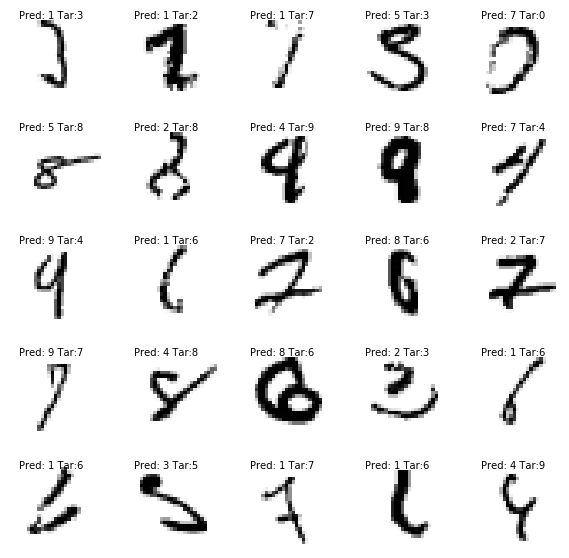

In [0]:
m1.sm.plot_misclassified_25()

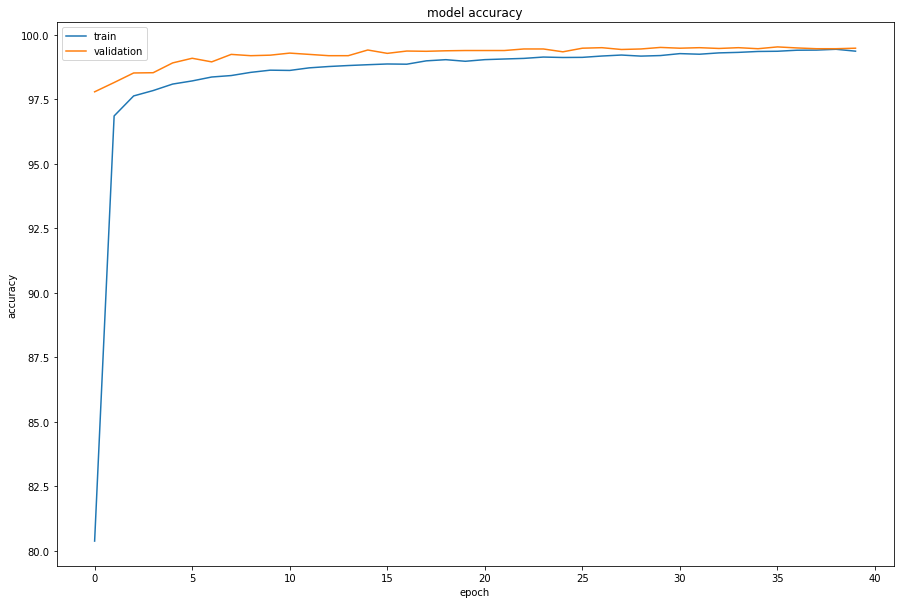

In [0]:
m1.sm.plot_accuracies()

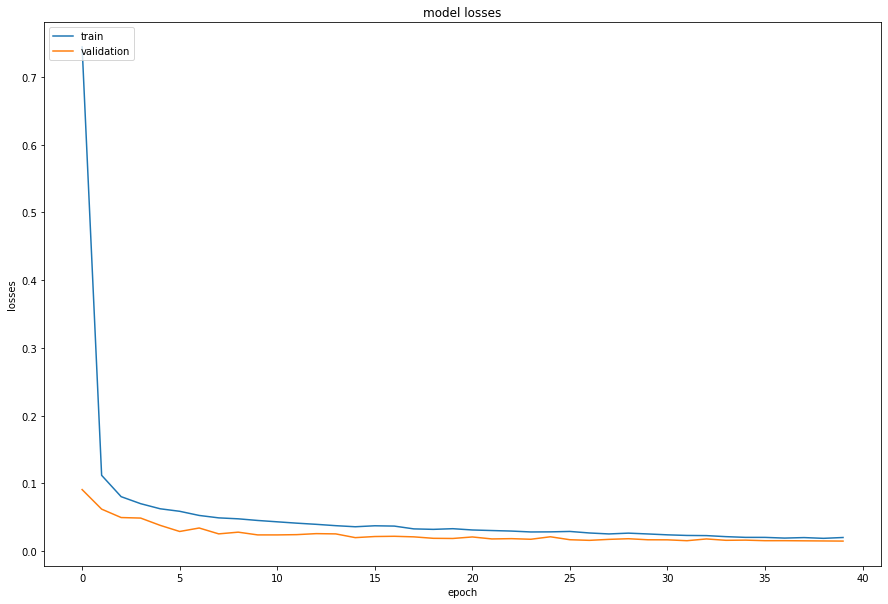

In [0]:
m1.sm.plot_losses()

In [0]:
m2=ModelTrainTester()

In [0]:
from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    m2.train(model, device, train_loader, optimizer, epoch, scheduler,1e-5)
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    #scheduler.step()
    m2.test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09366010129451752 Batch_id=468 Accuracy=80.38: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]

Epoch: 0 LR: [0.005636138390090167]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0843, Accuracy: 9788/10000 (97.88%)

EPOCH: 1


Loss=0.052712731063365936 Batch_id=468 Accuracy=96.79: 100%|██████████| 469/469 [00:17<00:00, 36.22it/s]

Epoch: 1 LR: [0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0708, Accuracy: 9793/10000 (97.93%)

EPOCH: 2


Loss=0.08420157432556152 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:16<00:00, 35.23it/s]

Epoch: 2 LR: [0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9863/10000 (98.63%)

EPOCH: 3


Loss=0.10973595082759857 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:17<00:00, 27.32it/s]

Epoch: 3 LR: [0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9840/10000 (98.40%)

EPOCH: 4


Loss=0.1478222906589508 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:17<00:00, 27.49it/s]

Epoch: 4 LR: [0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9842/10000 (98.42%)

EPOCH: 5


Loss=0.12450631707906723 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:16<00:00, 27.74it/s]

Epoch: 5 LR: [0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.034422747790813446 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:17<00:00, 27.32it/s]

Epoch: 6 LR: [0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9895/10000 (98.95%)

EPOCH: 7


Loss=0.036401841789484024 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]

Epoch: 7 LR: [0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9906/10000 (99.06%)

EPOCH: 8


Loss=0.03522254899144173 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]

Epoch: 8 LR: [0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.0530654676258564 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]


Epoch: 9 LR: [0.09358038101918463]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.08802496641874313 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]

Epoch: 10 LR: [0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.1188153401017189 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]

Epoch: 11 LR: [0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.037548430263996124 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:16<00:00, 36.37it/s]

Epoch: 12 LR: [0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.024767760187387466 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:17<00:00, 26.91it/s]

Epoch: 13 LR: [0.09874373753452848]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9903/10000 (99.03%)

EPOCH: 14


Loss=0.043354179710149765 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s]

Epoch: 14 LR: [0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9919/10000 (99.19%)

EPOCH: 15


Loss=0.0886751264333725 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]


Epoch: 15 LR: [0.09504327199257961]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.04425739869475365 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:16<00:00, 27.74it/s]

Epoch: 16 LR: [0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9916/10000 (99.16%)

EPOCH: 17


Loss=0.12599655985832214 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:16<00:00, 28.57it/s]

Epoch: 17 LR: [0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.015479390509426594 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]

Epoch: 18 LR: [0.08534693853699324]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.04884125292301178 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]


Epoch: 19 LR: [0.08116521259079444]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)

EPOCH: 20


Loss=0.04520068317651749 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]


Epoch: 20 LR: [0.0765915685289049]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.022200781852006912 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 29.18it/s]


Epoch: 21 LR: [0.07168352257909298]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.04169084504246712 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 27.96it/s]

Epoch: 22 LR: [0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH: 23


Loss=0.035284124314785004 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]

Epoch: 23 LR: [0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9946/10000 (99.46%)

EPOCH: 24


Loss=0.01731196790933609 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]

Epoch: 24 LR: [0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.30%)

EPOCH: 25


Loss=0.06428609788417816 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 28.91it/s]


Epoch: 25 LR: [0.0499882384554628]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9942/10000 (99.42%)

EPOCH: 26


Loss=0.028490755707025528 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]


Epoch: 26 LR: [0.04439011241507181]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 27


Loss=0.06955698132514954 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]

Epoch: 27 LR: [0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9949/10000 (99.49%)

EPOCH: 28


Loss=0.06504448503255844 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]


Epoch: 28 LR: [0.03347502312812102]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

EPOCH: 29


Loss=0.015390584245324135 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:16<00:00, 35.89it/s]

Epoch: 29 LR: [0.028295323462426913]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9947/10000 (99.47%)

EPOCH: 30


Loss=0.018734842538833618 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]


Epoch: 30 LR: [0.023388575212655503]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9949/10000 (99.49%)

EPOCH: 31


Loss=0.04746855050325394 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 28.45it/s]

Epoch: 31 LR: [0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9932/10000 (99.32%)

EPOCH: 32


Loss=0.01757701113820076 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]


Epoch: 32 LR: [0.014636545284495312]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9947/10000 (99.47%)

EPOCH: 33


Loss=0.037724629044532776 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]

Epoch: 33 LR: [0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9946/10000 (99.46%)

EPOCH: 34


Loss=0.0712667927145958 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s]

Epoch: 34 LR: [0.007657796669532729]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9947/10000 (99.47%)

EPOCH: 35


Loss=0.05284641310572624 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:16<00:00, 35.22it/s]

Epoch: 35 LR: [0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9949/10000 (99.49%)

EPOCH: 36


Loss=0.01584773138165474 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:16<00:00, 28.76it/s]

Epoch: 36 LR: [0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9950/10000 (99.50%)

EPOCH: 37


Loss=0.026525989174842834 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:16<00:00, 28.65it/s]


Epoch: 37 LR: [0.001251339077347576]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9949/10000 (99.49%)

EPOCH: 38


Loss=0.028397053480148315 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:16<00:00, 28.89it/s]


Epoch: 38 LR: [0.00031345040150706035]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9950/10000 (99.50%)

EPOCH: 39


Loss=0.029491376131772995 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:16<00:00, 29.29it/s]


Epoch: 39 LR: [4.0143079121884904e-07]

Test set: Average loss: 0.0150, Accuracy: 9950/10000 (99.50%)



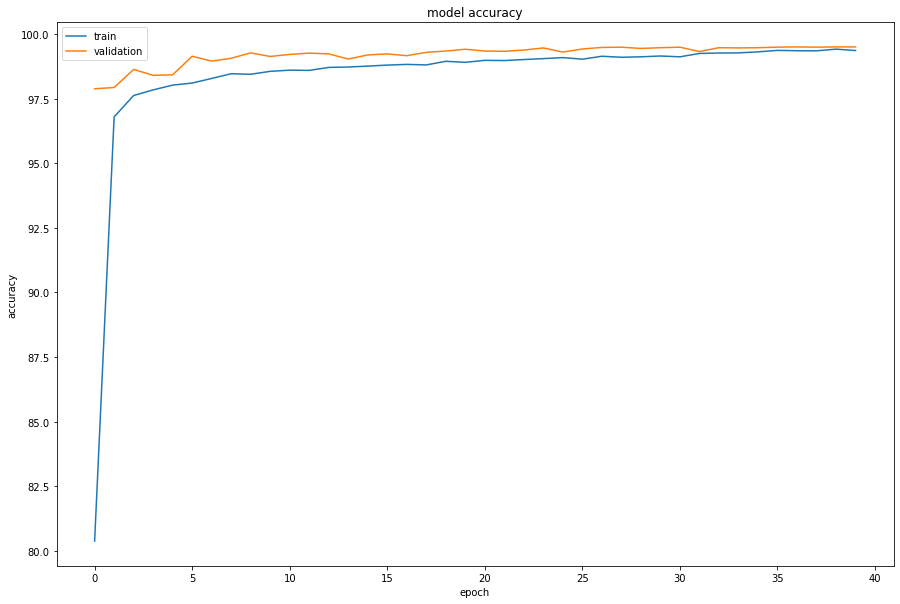

In [0]:
m2.sm.plot_accuracies()

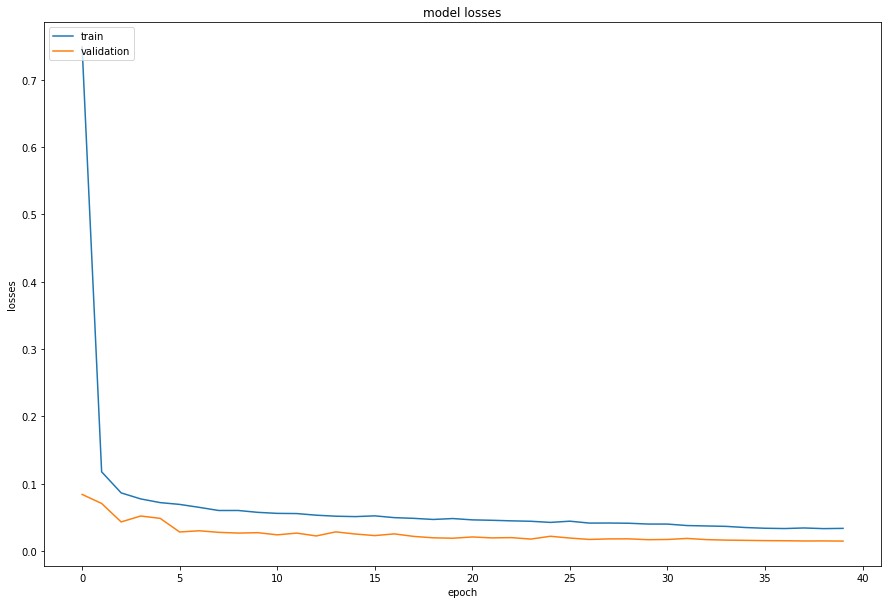

In [0]:
m2.sm.plot_losses()

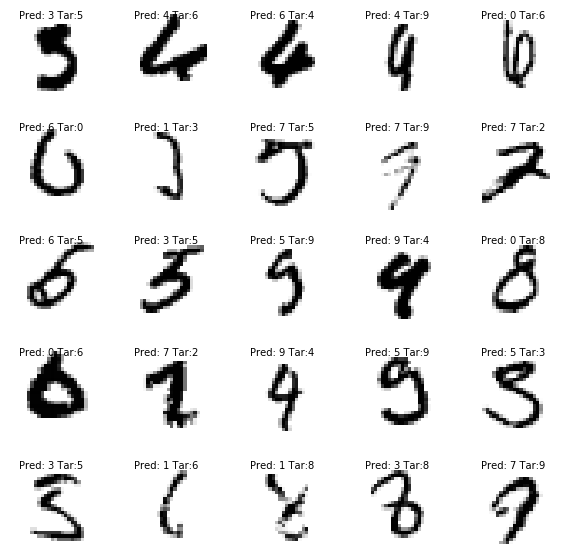

In [0]:
m2.sm.plot_misclassified_25()

In [0]:
m3=ModelTrainTester()

In [0]:
from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    m3.train(model, device, train_loader, optimizer, epoch, scheduler)
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    #scheduler.step()
    m3.test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08551744371652603 Batch_id=468 Accuracy=80.38: 100%|██████████| 469/469 [00:16<00:00, 28.78it/s]


Epoch: 0 LR: [0.005636138390090167]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0877, Accuracy: 9794/10000 (97.94%)

EPOCH: 1


Loss=0.04545918479561806 Batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]

Epoch: 1 LR: [0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0609, Accuracy: 9820/10000 (98.20%)

EPOCH: 2


Loss=0.058664724230766296 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]

Epoch: 2 LR: [0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9827/10000 (98.27%)

EPOCH: 3


Loss=0.10192625969648361 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]


Epoch: 3 LR: [0.028007736542228656]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.13292716443538666 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:15<00:00, 37.61it/s]

Epoch: 4 LR: [0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9859/10000 (98.59%)

EPOCH: 5


Loss=0.09452114254236221 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]

Epoch: 5 LR: [0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


Loss=0.01403490174561739 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:16<00:00, 34.67it/s]

Epoch: 6 LR: [0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.022521892562508583 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:15<00:00, 36.14it/s]

Epoch: 7 LR: [0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.05081221088767052 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]


Epoch: 8 LR: [0.08595533469319193]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.05189034715294838 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]

Epoch: 9 LR: [0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.1118459701538086 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]

Epoch: 10 LR: [0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.09195073693990707 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]


Epoch: 11 LR: [0.09999999856920878]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9914/10000 (99.14%)

EPOCH: 12


Loss=0.04899595305323601 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 29.89it/s]

Epoch: 12 LR: [0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.02979992888867855 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 30.40it/s]


Epoch: 13 LR: [0.09874373753452848]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9909/10000 (99.09%)

EPOCH: 14


Loss=0.035359229892492294 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]


Epoch: 14 LR: [0.09719022574054306]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.06625908613204956 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]

Epoch: 15 LR: [0.09504327199257961]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.0226499792188406 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 30.55it/s]


Epoch: 16 LR: [0.09232987547971035]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.09040556102991104 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 30.42it/s]

Epoch: 17 LR: [0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.007361277937889099 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 31.34it/s]

Epoch: 18 LR: [0.08534693853699324]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.013941635377705097 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 30.75it/s]

Epoch: 19 LR: [0.08116521259079444]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.016503922641277313 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]

Epoch: 20 LR: [0.0765915685289049]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.29%)

EPOCH: 21


Loss=0.0051884897984564304 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]

Epoch: 21 LR: [0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 22


Loss=0.037004441022872925 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]

Epoch: 22 LR: [0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.02623228169977665 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]

Epoch: 23 LR: [0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.00567143177613616 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 30.72it/s]

Epoch: 24 LR: [0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9921/10000 (99.21%)

EPOCH: 25


Loss=0.043754786252975464 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 36.64it/s]

Epoch: 25 LR: [0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9949/10000 (99.49%)

EPOCH: 26


Loss=0.008531719446182251 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]

Epoch: 26 LR: [0.04439011241507181]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

EPOCH: 27


Loss=0.03523874655365944 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]

Epoch: 27 LR: [0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.44%)

EPOCH: 28


Loss=0.052524495869874954 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]

Epoch: 28 LR: [0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9933/10000 (99.33%)

EPOCH: 29


Loss=0.006826683878898621 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]


Epoch: 29 LR: [0.028295323462426913]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)

EPOCH: 30


Loss=0.02131301909685135 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]


Epoch: 30 LR: [0.023388575212655503]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 31


Loss=0.028897970914840698 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]

Epoch: 31 LR: [0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9939/10000 (99.39%)

EPOCH: 32


Loss=0.013673245906829834 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]

Epoch: 32 LR: [0.014636545284495312]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9940/10000 (99.40%)

EPOCH: 33


Loss=0.023783588781952858 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]

Epoch: 33 LR: [0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9952/10000 (99.52%)

EPOCH: 34


Loss=0.0686817541718483 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]


Epoch: 34 LR: [0.007657796669532729]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 9945/10000 (99.45%)

EPOCH: 35


Loss=0.03747056424617767 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]

Epoch: 35 LR: [0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 9957/10000 (99.57%)

EPOCH: 36


Loss=0.005975633859634399 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 38.89it/s]

Epoch: 36 LR: [0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0142, Accuracy: 9954/10000 (99.54%)

EPOCH: 37


Loss=0.015569525770843029 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]

Epoch: 37 LR: [0.001251339077347576]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 9954/10000 (99.54%)

EPOCH: 38


Loss=0.02345135249197483 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]

Epoch: 38 LR: [0.00031345040150706035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 9958/10000 (99.58%)

EPOCH: 39


Loss=0.0052425614558160305 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]


Epoch: 39 LR: [4.0143079121884904e-07]

Test set: Average loss: 0.0133, Accuracy: 9959/10000 (99.59%)



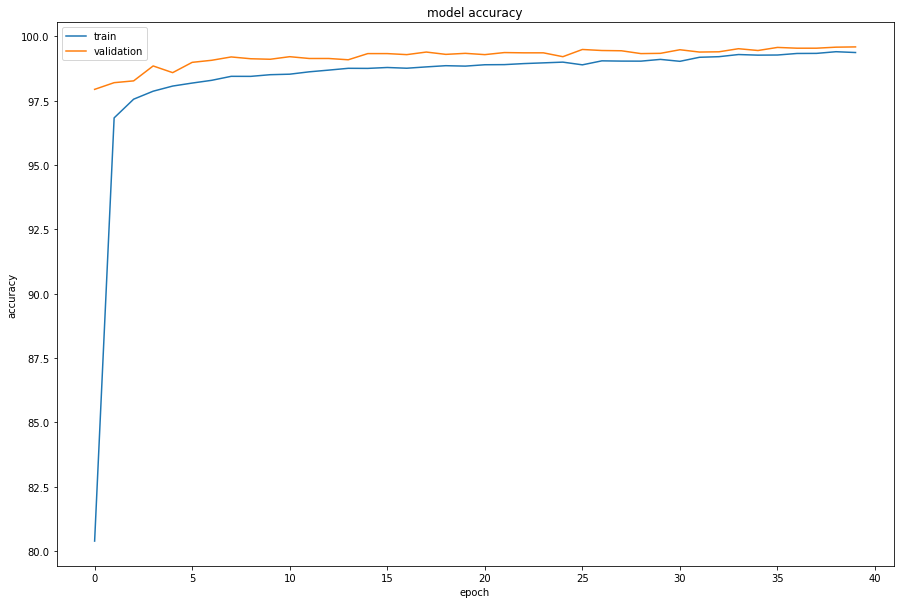

In [0]:
m3.sm.plot_accuracies()

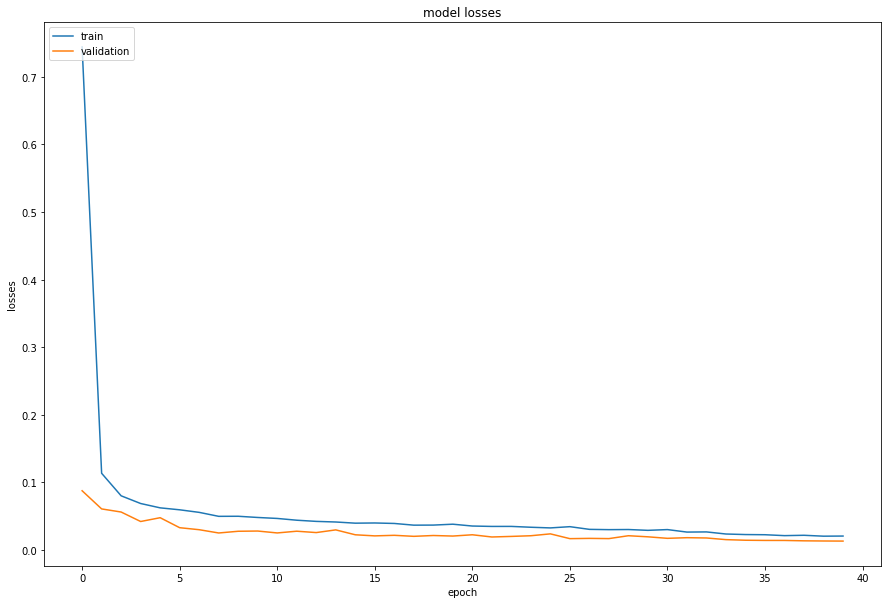

In [0]:
m3.sm.plot_losses()

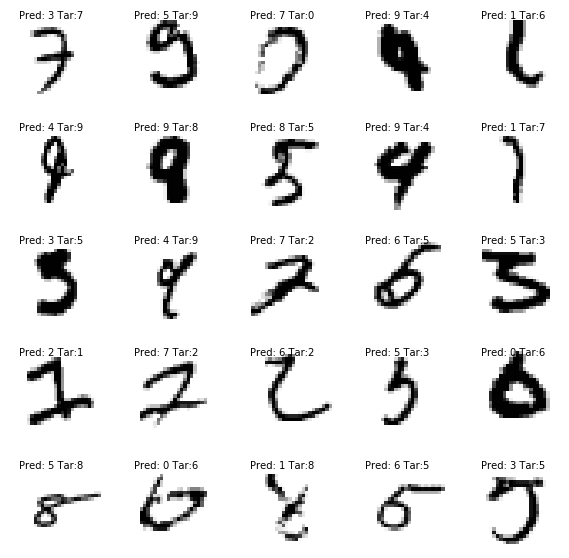

In [0]:
m3.sm.plot_misclassified_25()

In [0]:
m4=ModelTrainTester()


In [0]:
from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    m4.train(model, device, train_loader, optimizer, epoch, scheduler,1e-5)
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    #scheduler.step()
    m4.test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09658350050449371 Batch_id=468 Accuracy=80.37: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]


Epoch: 0 LR: [0.005636138390090167]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0890, Accuracy: 9786/10000 (97.86%)

EPOCH: 1


Loss=0.07644065469503403 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:16<00:00, 28.62it/s]

Epoch: 1 LR: [0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0604, Accuracy: 9816/10000 (98.16%)

EPOCH: 2


Loss=0.06862145662307739 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:16<00:00, 33.61it/s]

Epoch: 2 LR: [0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9850/10000 (98.50%)

EPOCH: 3


Loss=0.10324157774448395 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:16<00:00, 28.82it/s]

Epoch: 3 LR: [0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9868/10000 (98.68%)

EPOCH: 4


Loss=0.08933714032173157 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s]


Epoch: 4 LR: [0.03958747183126786]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0553, Accuracy: 9830/10000 (98.30%)

EPOCH: 5


Loss=0.12396371364593506 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]

Epoch: 5 LR: [0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.03379105404019356 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]

Epoch: 6 LR: [0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.01987934671342373 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:16<00:00, 31.89it/s]


Epoch: 7 LR: [0.07601547059053707]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.04785221815109253 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]

Epoch: 8 LR: [0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.06476865708827972 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:16<00:00, 28.76it/s]

Epoch: 9 LR: [0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9895/10000 (98.95%)

EPOCH: 10


Loss=0.10407470911741257 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:16<00:00, 34.62it/s]

Epoch: 10 LR: [0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9914/10000 (99.14%)

EPOCH: 11


Loss=0.10829028487205505 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]

Epoch: 11 LR: [0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9914/10000 (99.14%)

EPOCH: 12


Loss=0.05270684137940407 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]

Epoch: 12 LR: [0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


Loss=0.022009503096342087 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]


Epoch: 13 LR: [0.09874373753452848]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9896/10000 (98.96%)

EPOCH: 14


Loss=0.05829087644815445 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]

Epoch: 14 LR: [0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.11852559447288513 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 28.82it/s]

Epoch: 15 LR: [0.09504327199257961]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9921/10000 (99.21%)

EPOCH: 16


Loss=0.030993608757853508 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:17<00:00, 27.35it/s]

Epoch: 16 LR: [0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9927/10000 (99.27%)

EPOCH: 17


Loss=0.10057057440280914 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]

Epoch: 17 LR: [0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9919/10000 (99.19%)

EPOCH: 18


Loss=0.021781601011753082 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]

Epoch: 18 LR: [0.08534693853699324]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9923/10000 (99.23%)

EPOCH: 19


Loss=0.02283114567399025 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]


Epoch: 19 LR: [0.08116521259079444]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)

EPOCH: 20


Loss=0.03248528763651848 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]

Epoch: 20 LR: [0.0765915685289049]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9918/10000 (99.18%)

EPOCH: 21


Loss=0.02046060934662819 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]

Epoch: 21 LR: [0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH: 22


Loss=0.05872929468750954 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.31it/s]

Epoch: 22 LR: [0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.03389814496040344 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 34.71it/s]

Epoch: 23 LR: [0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.021827271208167076 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]

Epoch: 24 LR: [0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9910/10000 (99.10%)

EPOCH: 25


Loss=0.06683085858821869 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]

Epoch: 25 LR: [0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 26


Loss=0.024802830070257187 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]

Epoch: 26 LR: [0.04439011241507181]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

EPOCH: 27


Loss=0.06443803012371063 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 27.82it/s]

Epoch: 27 LR: [0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9938/10000 (99.38%)

EPOCH: 28


Loss=0.06881216913461685 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]

Epoch: 28 LR: [0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9925/10000 (99.25%)

EPOCH: 29


Loss=0.015537731349468231 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 28.33it/s]

Epoch: 29 LR: [0.028295323462426913]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 30


Loss=0.04095076024532318 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]


Epoch: 30 LR: [0.023388575212655503]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 31


Loss=0.03541513532400131 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]

Epoch: 31 LR: [0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)

EPOCH: 32


Loss=0.02442226931452751 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]


Epoch: 32 LR: [0.014636545284495312]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 33


Loss=0.0358562245965004 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 29.36it/s]

Epoch: 33 LR: [0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9946/10000 (99.46%)

EPOCH: 34


Loss=0.07952363044023514 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]


Epoch: 34 LR: [0.007657796669532729]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9944/10000 (99.44%)

EPOCH: 35


Loss=0.03560703247785568 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:16<00:00, 29.23it/s]

Epoch: 35 LR: [0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9946/10000 (99.46%)

EPOCH: 36


Loss=0.014025413431227207 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:16<00:00, 27.97it/s]

Epoch: 36 LR: [0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 9950/10000 (99.50%)

EPOCH: 37


Loss=0.02347249537706375 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]

Epoch: 37 LR: [0.001251339077347576]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9952/10000 (99.52%)

EPOCH: 38


Loss=0.02210637740790844 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:15<00:00, 29.36it/s]


Epoch: 38 LR: [0.00031345040150706035]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0146, Accuracy: 9950/10000 (99.50%)

EPOCH: 39


Loss=0.015228102914988995 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:16<00:00, 36.31it/s]

Epoch: 39 LR: [4.0143079121884904e-07]



Test set: Average loss: 0.0144, Accuracy: 9950/10000 (99.50%)



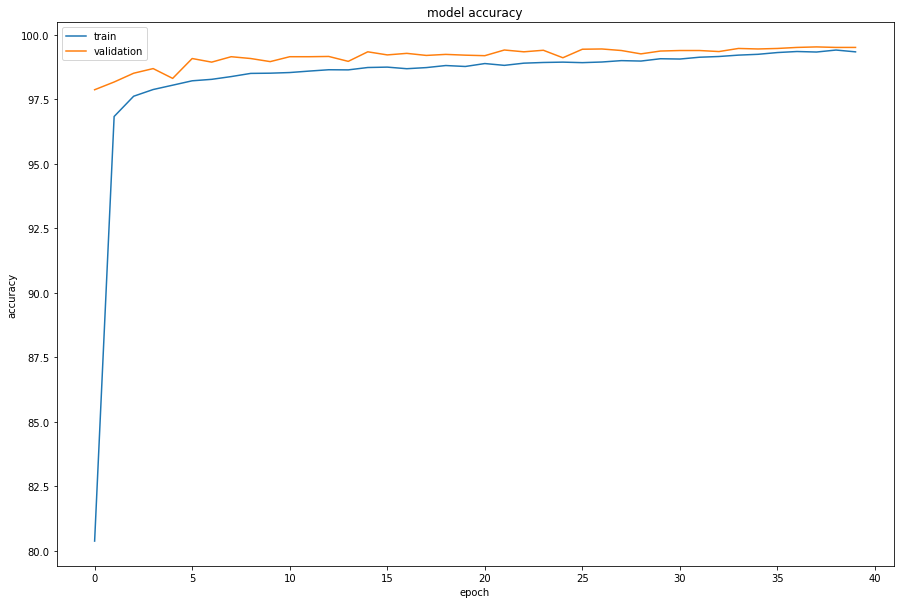

In [0]:
m4.sm.plot_accuracies()

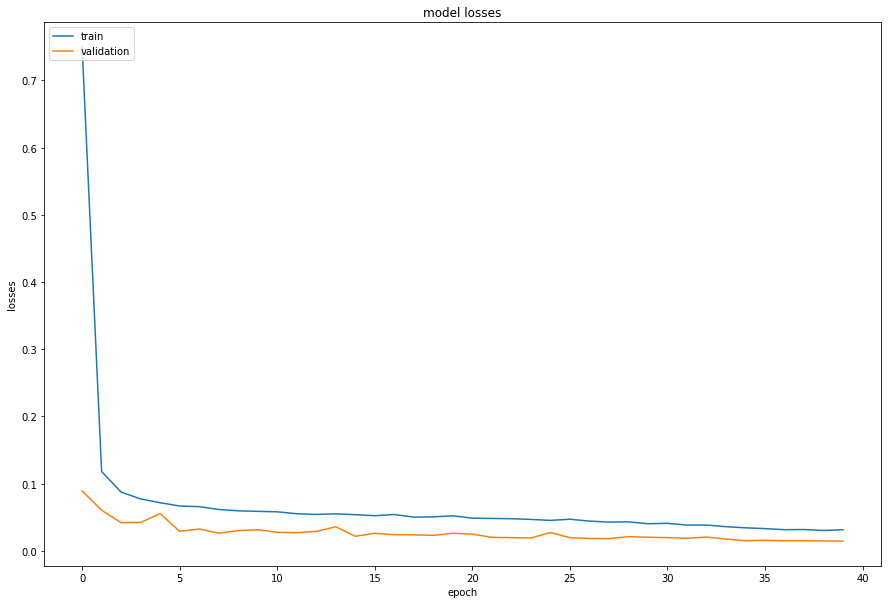

In [0]:
m4.sm.plot_losses()

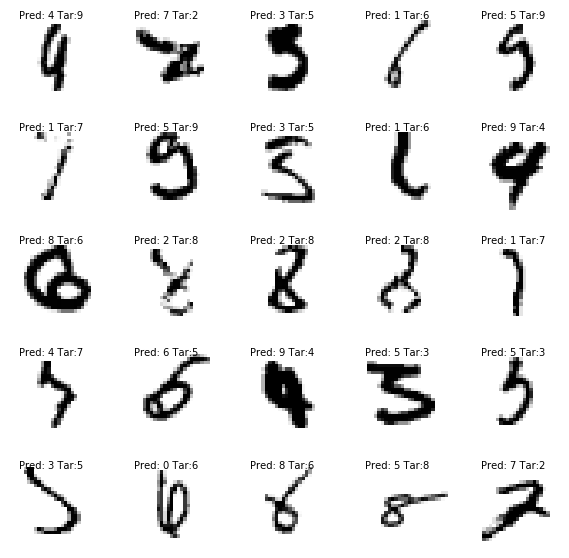

In [0]:
m4.sm.plot_misclassified_25()

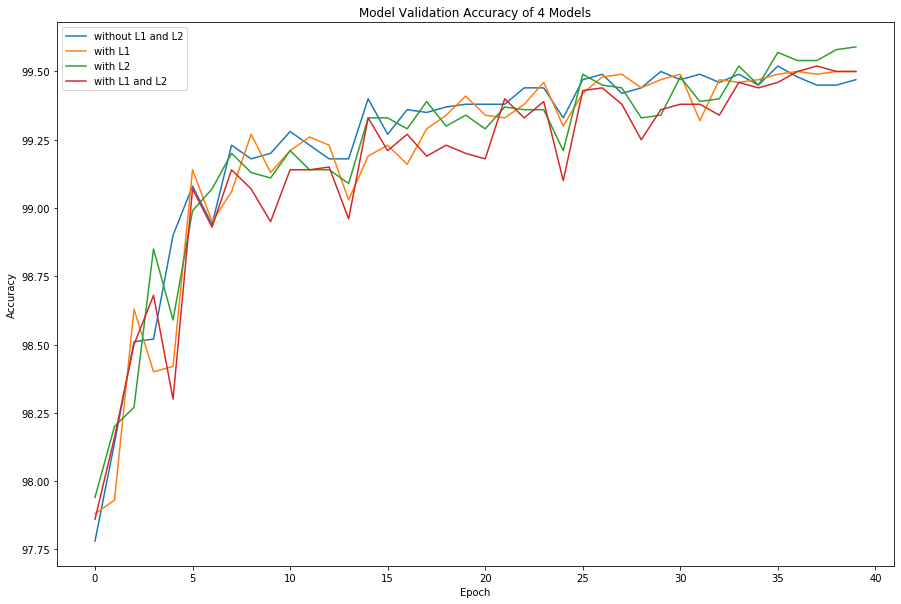

In [0]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(m1.sm.data["test_accuracy"])
ax.plot(m2.sm.data["test_accuracy"])
ax.plot(m3.sm.data["test_accuracy"])
ax.plot(m4.sm.data["test_accuracy"])
ax.set(title="Model Validation Accuracy of 4 Models", ylabel="Accuracy", xlabel="Epoch")
ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
plt.savefig("Accuracyof4models.png")
plt.show()


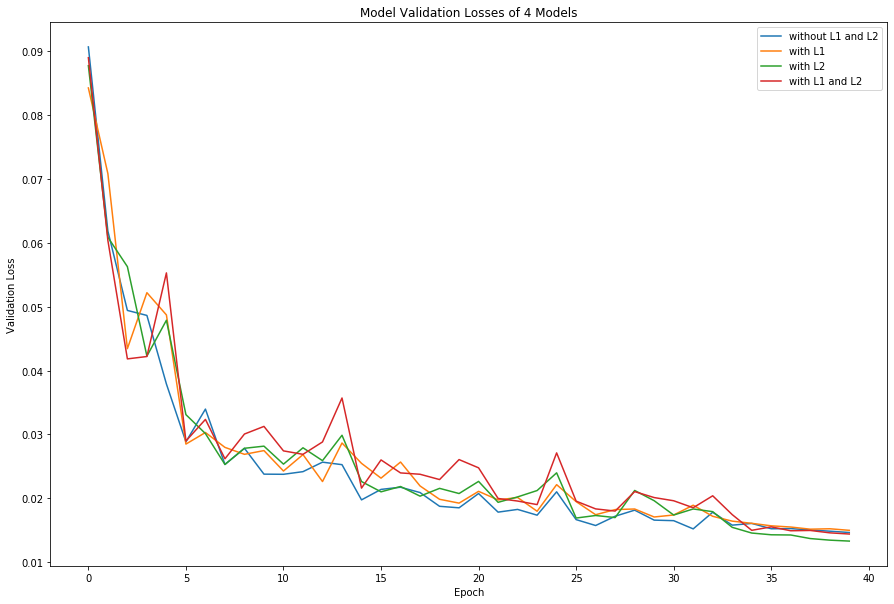

In [0]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(m1.sm.data["test_loss"])
ax.plot(m2.sm.data["test_loss"])
ax.plot(m3.sm.data["test_loss"])
ax.plot(m4.sm.data["test_loss"])
ax.set(title="Model Validation Losses of 4 Models", ylabel="Validation Loss", xlabel="Epoch")
ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
plt.savefig("ValidationLossof4models.png")
plt.show()


In [0]:
https://github.com/Lakshman511/EVA4/blob/master/S6/All_accuracy.png